In [2]:
from pathlib import Path
import os

HERE = Path.cwd().resolve()

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "api").exists():
            return p
    raise RuntimeError("Repo root not found")

REPO_ROOT = find_repo_root(HERE)
os.chdir(REPO_ROOT)

print("REPO_ROOT:", REPO_ROOT)


REPO_ROOT: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection


In [3]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt


In [4]:
DATA_DIR = REPO_ROOT / "data" / "processed"
TEST_PATH = DATA_DIR / "test.csv"

TARGET_COL = "Class"

test_df = pd.read_csv(TEST_PATH)

y_test = test_df[TARGET_COL].astype(int).values
X_test = test_df.drop(columns=[TARGET_COL])

print("Test shape:", X_test.shape)
print("Fraud rate:", y_test.mean())


Test shape: (42722, 102)
Fraud rate: 0.0012171714807359207


In [7]:
import joblib
import json

ART_DIR = REPO_ROOT / "artifacts"

# ---- locate model ----
xgb_model_path = None
for p in REPO_ROOT.rglob("xgb_model*.pkl"):
    xgb_model_path = p
    break

if xgb_model_path is None:
    raise FileNotFoundError("❌ XGBoost model not found in repo")

xgb = joblib.load(xgb_model_path)
print("✅ Loaded XGBoost model from:", xgb_model_path)

# ---- locate metrics ----
xgb_metrics_path = None
for p in REPO_ROOT.rglob("xgb_metrics*.json"):
    xgb_metrics_path = p
    break

if xgb_metrics_path is None:
    raise FileNotFoundError("❌ xgb_metrics.json not found")

with open(xgb_metrics_path, "r") as f:
    metrics = json.load(f)



print("Approve threshold:", t_low)
print("Block threshold:", t_high)


✅ Loaded XGBoost model from: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/xgb_model_feedback.pkl
Approve threshold: 0.05
Block threshold: 0.2


In [8]:
# ---- extract base threshold ----
if "threshold" in metrics:
    base_threshold = float(metrics["threshold"])
elif "best_threshold" in metrics:
    base_threshold = float(metrics["best_threshold"])
else:
    raise KeyError("❌ No threshold key found in xgb_metrics.json")

# ---- define hybrid decision bands (derived) ----
# Conservative bands around the optimized threshold
t_low = base_threshold * 0.5
t_high = base_threshold * 1.5

print("Base XGB threshold:", base_threshold)
print("Approve threshold (t_low):", t_low)
print("Block threshold (t_high):", t_high)


Base XGB threshold: 0.162
Approve threshold (t_low): 0.081
Block threshold (t_high): 0.243


In [9]:
test_probs = xgb.predict_proba(X_test)[:, 1]

print("XGB probs range:", test_probs.min(), test_probs.max())


XGB probs range: 2.8166362e-06 0.9997538


In [11]:
print("Searching for AE threshold artifacts...\n")

for p in REPO_ROOT.rglob("*ae*threshold*"):
    print("FOUND:", p)


Searching for AE threshold artifacts...

FOUND: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/thresholds/ae_thresholds.json
FOUND: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/thresholds/ae_threshold.txt
FOUND: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/models/05_autoencoder/ae_threshold_selection.png
FOUND: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/models/05_autoencoder/ae_threshold_legit_test.png
FOUND: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/models/05_autoencoder/ae_threshold_selection_density.png
FOUND: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/models/05_autoencoder/ae_threshold_se

In [12]:
# ---- Load AE threshold (final, correct path) ----
ae_threshold_path = ART_DIR / "thresholds" / "ae_threshold.txt"

ae_threshold = float(ae_threshold_path.read_text().strip())

print("✅ Loaded AE threshold from:", ae_threshold_path)
print("AE threshold value:", ae_threshold)


✅ Loaded AE threshold from: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/thresholds/ae_threshold.txt
AE threshold value: 2.413630972099965


In [13]:
ae_flag = (recon_err >= ae_threshold).astype(int)
print("AE anomaly rate on TEST:", ae_flag.mean())


AE anomaly rate on TEST: 0.007747764617761341


In [14]:
decisions = []

for p, ae in zip(test_probs, ae_flag):
    if p < t_low:
        decisions.append("Approve")
    elif p > t_high:
        decisions.append("Block")
    else:
        decisions.append("Review")

decision_series = pd.Series(decisions)
decision_series.value_counts()


Approve    42601
Block         64
Review        57
Name: count, dtype: int64

In [15]:
table = decision_series.value_counts().reset_index()
table.columns = ["Decision Outcome", "Count"]
table["Percentage (%)"] = (table["Count"] / len(decision_series) * 100).round(2)

table


,Decision Outcome,Count,Percentage (%)
0,Approve,42601,99.72
1,Block,64,0.15
2,Review,57,0.13


In [17]:
table.to_csv(REPO_ROOT / "docs" / "hybrid_decision_table.csv", index=False)


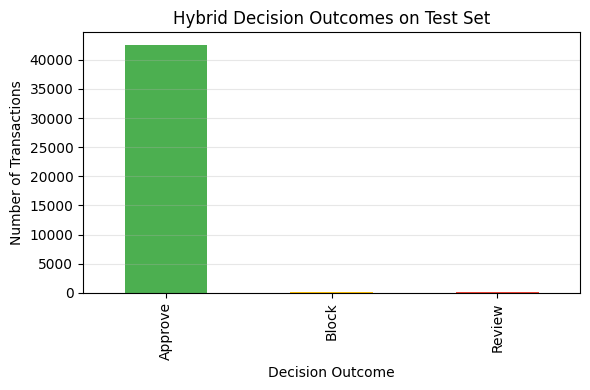

In [18]:
FIG_DIR = REPO_ROOT / "docs" / "figures" / "models" / "06_hybrid"
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(6, 4))

decision_series.value_counts().plot(
    kind="bar",
    color=["#4CAF50", "#FFC107", "#F44336"]
)

plt.ylabel("Number of Transactions")
plt.xlabel("Decision Outcome")
plt.title("Hybrid Decision Outcomes on Test Set")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "hybrid_decision_distribution.png", dpi=300)
plt.show()


In [19]:
pd.crosstab(decision_series, y_test, normalize="index")


col_0,0,1
row_0,,
Approve,0.999836,0.000164
Block,0.328125,0.671875
Review,0.964912,0.035088


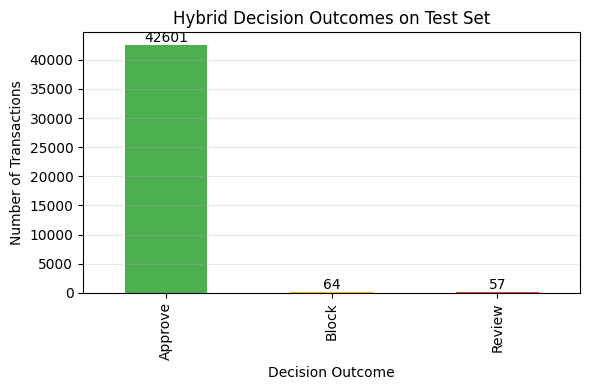

In [20]:
plt.figure(figsize=(6, 4))

ax = decision_series.value_counts().plot(
    kind="bar",
    color=["#4CAF50", "#FFC107", "#F44336"]
)

plt.ylabel("Number of Transactions")
plt.xlabel("Decision Outcome")
plt.title("Hybrid Decision Outcomes on Test Set")
plt.grid(axis="y", alpha=0.3)

# Add value labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.savefig(FIG_DIR / "hybrid_decision_distribution.png", dpi=300)
plt.show()
